tb - 7/8/2022 - This notebook's goal is to compare the quality of the NNs trained on (-4K) by Jerry and that of the NNs used in the climate-invariant manuscript

# Imports and Initialization

## Imports

In [8]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
#from cbrain.imports import *
# from cbrain.cam_constants import *
# from cbrain.utils import *
# from cbrain.layers import *
# from cbrain.data_generator import DataGenerator
# from cbrain.climate_invariant import *
# from cbrain.climate_invariant_utils import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
#import tensorflow_probability as tfp
import xarray as xr
import numpy as np

# import cartopy
# import cartopy.feature as cfeature
# import cartopy.crs as ccrs

#from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import matplotlib.ticker as mticker
import matplotlib.transforms as mtrans
import matplotlib.pylab as plb

import pandas as pd
import pickle as pkl
import warnings

In [9]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

In [10]:
# Load coordinates (just pick any file from the climate model run)

# GP path below
path_0K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/'
coor = xr.open_dataset(path_0K+"AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-09-02-00000.nc")

lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

## Paths

### Tom

In [11]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_array = {}
path_array['cold'] = [path_data+'2021_03_18_O3_TRAIN_M4K_shuffle.nc',
                      path_data+'2021_03_18_O3_VALID_M4K.nc',
                      path_data+'2021_03_18_O3_TEST_M4K.nc']
path_array['hot'] = [path_data+'2021_03_18_O3_TRAIN_P4K_shuffle.nc',
                     path_data+'2021_03_18_O3_VALID_P4K.nc',
                     path_data+'2021_03_18_O3_TEST_P4K.nc']
path_array['both'] = [path_data+'2022_04_18_TRAIN_M4K_P4K_shuffle.nc',
                      path_data+'2022_04_18_VALID_M4K_P4K.nc',
                      path_data+'2022_04_18_TEST_M4K_P4K.nc']
path_array['medium'] = [path_data+'2021_01_24_O3_TRAIN_shuffle.nc',
                        path_data+'2021_01_24_O3_VALID.nc',
                        path_data+'2021_01_24_O3_TEST.nc']

In [12]:
path_Tom = ['/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5',
            '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_06_13_NN_RH.hdf5']

In [13]:
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
scale_dict_RH = scale_dict.copy()
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%
path_train_RH = path_data + '2021_01_24_O3_small_shuffle.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_train_BMSE = path_data + '2021_06_16_BMSE_small_shuffle.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'
path_train_LHF_nsDELQ = path_data + '2021_02_01_O3_LHF_nsQ_small_shuffle.nc'

In [14]:
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions

In [15]:
path_Tom_2 = ['/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_CLR_m4K_BF.hdf5',
              '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_m4K_BF.hdf5']

In [16]:
in_vars_2 = ['TBP','QBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars_2 = ['TPHYSTND','PHQ'] # and we output the response of clouds/storms to these climate conditions

### Jerry

In [17]:
path_Jerry = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/AdaptedPreprocessing/Jerry_Bridges/'
path_J_h5 = ['specifich5/spehum','relativeh5/relhum']
path_J_norm = ['specific64/','relative64/']
path_J_loss = ['/fast/jerryl9/pythonNotebooks/forTom/AdaptedPreprocessing/specificHistory.txt',
              '/fast/jerryl9/pythonNotebooks/forTom/AdaptedPreprocessing/relativeHistory.txt']

In [18]:
path_div = [path_Jerry+path_J_norm[0]+'inp_div_Specific64.txt',
           path_Jerry+path_J_norm[1]+'inp_div_Relative64.txt']
path_sub = [path_Jerry+path_J_norm[0]+'inp_sub_Specific64.txt',
           path_Jerry+path_J_norm[1]+'inp_sub_Relative64.txt']
path_out = [path_Jerry+path_J_norm[0]+'out_scale_Specific64.txt',
            path_Jerry+path_J_norm[1]+'out_scale_Relative64.txt']

## Load models

In [19]:
MODEL = {}

for ipath,path in enumerate(path_Tom):
    print('path=',path)
    MODEL[path] = load_model(path,compile=False)

path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5


2023-05-12 02:38:09.929211: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 02:38:09.940299: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-12 02:38:10.526557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.74GiB deviceMemoryBandwidth: 836.37GiB/s
2023-05-12 02:38:10.526943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz 

path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_06_13_NN_RH.hdf5


In [20]:
MODEL2 = {}

for ipath,path in enumerate(path_Tom_2):
    print('path=',path)
    MODEL2[path] = load_model(path,compile=False)

path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_CLR_m4K_BF.hdf5
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_m4K_BF.hdf5


In [21]:
Inp_name = ['Q','RH']

In [22]:
MODELJ = {}

for iinput,inp in enumerate(path_J_h5):
    MODELJ[Inp_name[iinput]] = {}
    for dropout in range(5):
        MODELJ[Inp_name[iinput]][dropout] = {}
        for BN in (['True','False']):
            MODELJ[Inp_name[iinput]][dropout][BN] = \
            load_model(path_Jerry+inp+'_version_'+str(dropout)+'_'+BN+'.h5',compile=False)

## Load normalization and loss files for Jerry's case

In [23]:
SUB = {}; DIV = {}; OUT = {}

In [24]:
for iinp in range(2):
    DIV[iinp] = (pd.read_csv(path_div[iinp], sep=" ", header=None).values)[:,0]
    SUB[iinp] = (pd.read_csv(path_sub[iinp], sep=" ", header=None).values)[:,0]
    OUT[iinp] = (pd.read_csv(path_out[iinp], sep=" ", header=None).values)[:,0]

Careful because Jerry's input order is ['TBP','QBP','PS','SOLIN','SHFLX','LHFLX'], i.e., T and Q are inverted, and his output order is ['TPHYSTND','PHQ'], so again, temperature comes first.

In [25]:
LOSS = {}

In [17]:
test = pd.read_csv(path_J_loss[0])

In [18]:
for i in range(test.shape[0]):
    print((test.values)[i])

['spehum_version_0.0False.h5']
['Epoch 1/100']
['5766/5766 - 39s - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0034 - val_mse: 0.0034']
['Epoch 2/100']
['5766/5766 - 29s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0033 - val_mse: 0.0033']
['Epoch 3/100']
['5766/5766 - 29s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0032 - val_mse: 0.0032']
['Epoch 4/100']
['5766/5766 - 28s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032']
['Epoch 5/100']
['5766/5766 - 28s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032']
['Epoch 6/100']
['5766/5766 - 29s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032']
['Epoch 7/100']
['5766/5766 - 28s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032']
['Epoch 8/100']
['5766/5766 - 29s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032']
['Epoch 9/100']
['5766/5766 - 28s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0031 - val_mse: 0.0031']
['Epoch 10/100']
['5766/5766 - 28s - loss: 0.0031 -

In [19]:
test = pd.read_csv(path_J_loss[1])

In [20]:
for i in range(test.shape[0]):
    print((test.values)[i])

['relhum_version_0.0False.h5']
['Epoch 1/100']
['5766/5766 - 39s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0033 - val_mse: 0.0033']
['Epoch 2/100']
['5766/5766 - 29s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0033 - val_mse: 0.0033']
['Epoch 3/100']
['5766/5766 - 28s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032']
['Epoch 4/100']
['5766/5766 - 27s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032']
['Epoch 5/100']
['5766/5766 - 27s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0031 - val_mse: 0.0031']
['Epoch 6/100']
['5766/5766 - 28s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0031 - val_mse: 0.0031']
['Epoch 7/100']
['5766/5766 - 28s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0031 - val_mse: 0.0031']
['Epoch 8/100']
['5766/5766 - 28s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0031 - val_mse: 0.0031']
['Epoch 9/100']
['5766/5766 - 28s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0031 - val_mse: 0.0031']
['Epoch 10/100']
['5766/5766 - 27s - loss: 0.0031 -

## Define generators

In [23]:
def train_gen_rescaling(input_rescaling,path_norm,path_train,scale_dict):
    return DataGeneratorCI(
        data_fn = path_train,
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [24]:
train_gen_RH = train_gen_rescaling(['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX'],
                                   path_norm_RH,path_train_RH,scale_dict_RH)
train_gen_BMSE = train_gen_rescaling(['QBP','BMSE','PS', 'SOLIN', 'SHFLX', 'LHFLX'],
                                     path_norm_BMSE,path_train_BMSE,scale_dict)
train_gen_LHF_nsDELQ = train_gen_rescaling(['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsDELQ'],
                                           path_norm_LHF_nsDELQ,path_train_LHF_nsDELQ,scale_dict)

In [25]:
Qscaling_array = [None,'RH']
Tscaling_array = [None,None]
LHFscaling_array = [None,None]

In [26]:
inp_sub_Qarray = [None,train_gen_RH.input_transform.sub]
inp_div_Qarray = [None,train_gen_RH.input_transform.div]
inp_sub_Tarray = [None,None]
inp_div_Tarray = [None,None]
inp_sub_LHFarray = [None,None]
inp_div_LHFarray = [None,None]

In [27]:
test_m4K = {}
test_p4K = {}

In [28]:
DataGeneratorCI

cbrain.climate_invariant.DataGeneratorCI

In [31]:
for ipath,path in enumerate(path_Tom):
    test_m4K[path] = DataGeneratorCI(data_fn = path_array['cold'][2],
                                      input_vars=in_vars,
                                      output_vars=out_vars,
                                      norm_fn=path_input_norm,
                                      input_transform=('mean', 'maxrs'),
                                      output_transform=scale_dict,
                                      batch_size=8192,
                                      shuffle=False,
                                      xarray=False,
                                      var_cut_off=None,
                                      Qscaling=Qscaling_array[ipath],
                                      Tscaling=Tscaling_array[ipath],
                                      LHFscaling=LHFscaling_array[ipath],
                                      SHFscaling=None,
                                      output_scaling=False,
                                      interpolate=False,
                                      hyam=hyam,hybm=hybm,
                                      inp_sub_Qscaling=inp_sub_Qarray[ipath],
                                      inp_div_Qscaling=inp_div_Qarray[ipath],
                                      inp_sub_Tscaling=inp_sub_Tarray[ipath],
                                      inp_div_Tscaling=inp_div_Tarray[ipath],
                                      inp_sub_LHFscaling=inp_sub_LHFarray[ipath],
                                      inp_div_LHFscaling=inp_div_LHFarray[ipath],
                                      inp_sub_SHFscaling=None,
                                      inp_div_SHFscaling=None,
                                      lev=None, interm_size=40,
                                      lower_lim=6,is_continous=True,Tnot=5,
                                      epsQ=1e-3,epsT=1,mode='train')
    test_p4K[path] = DataGeneratorCI(data_fn = path_array['hot'][2],
                                      input_vars=in_vars,
                                      output_vars=out_vars,
                                      norm_fn=path_input_norm,
                                      input_transform=('mean', 'maxrs'),
                                      output_transform=scale_dict,
                                      batch_size=8192,
                                      shuffle=False,
                                      xarray=False,
                                      var_cut_off=None,
                                      Qscaling=Qscaling_array[ipath],
                                      Tscaling=Tscaling_array[ipath],
                                      LHFscaling=LHFscaling_array[ipath],
                                      SHFscaling=None,
                                      output_scaling=False,
                                      interpolate=False,
                                      hyam=hyam,hybm=hybm,
                                      inp_sub_Qscaling=inp_sub_Qarray[ipath],
                                      inp_div_Qscaling=inp_div_Qarray[ipath],
                                      inp_sub_Tscaling=inp_sub_Tarray[ipath],
                                      inp_div_Tscaling=inp_div_Tarray[ipath],
                                      inp_sub_LHFscaling=inp_sub_LHFarray[ipath],
                                      inp_div_LHFscaling=inp_div_LHFarray[ipath],
                                      inp_sub_SHFscaling=None,
                                      inp_div_SHFscaling=None,
                                      lev=None, interm_size=40,
                                      lower_lim=6,is_continous=True,Tnot=5,
                                      epsQ=1e-3,epsT=1,mode='train')

In [36]:
test2_m4K = {}; test2_p4K = {};

In [37]:
for ipath,path in enumerate(path_Tom_2):
    test2_m4K[path] = DataGeneratorCI(data_fn = path_array['cold'][2],
                                  input_vars=in_vars_2,
                                  output_vars=out_vars_2,
                                  norm_fn=path_input_norm,
                                  input_transform=('mean', 'maxrs'),
                                  output_transform=scale_dict,
                                  batch_size=8192,
                                  shuffle=False,
                                  xarray=False,
                                  var_cut_off=None,
                                  hyam=hyam,hybm=hybm,
                                  lev=None, interm_size=40,
                                  lower_lim=6,is_continous=True,Tnot=5,
                                  epsQ=1e-3,epsT=1,mode='train')
    
    test2_p4K[path] = DataGeneratorCI(data_fn = path_array['hot'][2],
                                  input_vars=in_vars_2,
                                  output_vars=out_vars_2,
                                  norm_fn=path_input_norm,
                                  input_transform=('mean', 'maxrs'),
                                  output_transform=scale_dict,
                                  batch_size=8192,
                                  shuffle=False,
                                  xarray=False,
                                  var_cut_off=None,
                                  hyam=hyam,hybm=hybm,
                                  lev=None, interm_size=40,
                                  lower_lim=6,is_continous=True,Tnot=5,
                                  epsQ=1e-3,epsT=1,mode='train')

# Calculate offline MSE/R$^2$ for a small sample of each set

In [34]:
# Subsampling parameters
lat_ind = np.arange(0,64)
Nbatches = 50
b_random = np.random.choice(np.linspace(0,5700,5701),size=((Nbatches,)),replace=False).astype('int')

In [40]:
MSE = {}; MSE_gen = {}; INP = {}; VAR = {}; MSEJ = {}; MSEJ_gen = {}; VAR_gen = {}; 

## Tom's NNs

In [41]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    MSE[dataset] = {}; INP[dataset] = {}; VAR[dataset] = {}; 
    MSE_gen[dataset] = {}; VAR_gen[dataset] = {};
    MSEJ[dataset] = {}; MSEJ_gen[dataset] = {};
    
    if idataset==0: train_gen_array = test_m4K
    elif idataset==1: train_gen_array = test_p4K
    
    for ipath,path in enumerate(path_Tom):
        print('path=',path)
            
        model = MODEL[path]
        train_gen = train_gen_array[path]
            
        for ibatch,ib in enumerate(b_random):
            print('ibatch=',ibatch,'/',Nbatches-1,' & ib',ib,end="\r")

            inp = train_gen[ib][0]
            tru = train_gen[ib][1]
            prd = model.predict_on_batch(inp)

            inp_geo = np.reshape(inp,(64,128,inp.shape[1],1))
            prd_geo = np.reshape(prd,(64,128,prd.shape[1]))
            tru_geo = np.reshape(tru,(64,128,tru.shape[1]))

            mse = np.expand_dims(np.mean((tru_geo-prd_geo)**2,axis=2),axis=2)
            var = np.expand_dims(tru_geo,axis=2)
            mse_gen = np.expand_dims(np.mean((tru_geo-prd_geo)[lat_ind,:,:]**2,axis=(0,1)),axis=1)

            if ibatch==0:
                MSE[dataset][path] = mse; 
                VAR[dataset][path] = var; 
                INP[dataset][path] = inp_geo;
                MSE_gen[dataset][path] = mse_gen;
            else:
                MSE[dataset][path] = np.concatenate((MSE[dataset][path],mse),axis=2)
                VAR[dataset][path] = np.concatenate((VAR[dataset][path],var),axis=2)
                INP[dataset][path] = np.concatenate((INP[dataset][path],inp_geo),axis=3)
                MSE_gen[dataset][path] = np.concatenate((MSE_gen[dataset][path],mse_gen),axis=1)

idataset= 0  & dataset= AQ-4K
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_06_13_NN_RH.hdf5
idataset= 1  & dataset= AQ+4K
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_06_13_NN_RH.hdf5


## Tom's NNs version 2

In [42]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    if idataset==0: train_gen_array = test2_m4K
    elif idataset==1: train_gen_array = test2_p4K
    
    for ipath,path in enumerate(path_Tom_2):
        print('path=',path)
            
        model = MODEL2[path]
        train_gen = train_gen_array[path]
            
        for ibatch,ib in enumerate(b_random):
            print('ibatch=',ibatch,'/',Nbatches-1,' & ib',ib,end="\r")

            inp = train_gen[ib][0]
            tru = train_gen[ib][1]
            prd = model.predict_on_batch(inp)

            inp_geo = np.reshape(inp,(64,128,inp.shape[1],1))
            prd_geo = np.reshape(prd,(64,128,prd.shape[1]))
            tru_geo = np.reshape(tru,(64,128,tru.shape[1]))

            mse = np.expand_dims(np.mean((tru_geo-prd_geo)**2,axis=2),axis=2)
            var = np.expand_dims(tru_geo,axis=2)
            mse_gen = np.expand_dims(np.mean((tru_geo-prd_geo)[lat_ind,:,:]**2,axis=(0,1)),axis=1)

            if ibatch==0:
                MSE[dataset][path] = mse; 
                VAR[dataset][path] = var; 
                INP[dataset][path] = inp_geo;
                MSE_gen[dataset][path] = mse_gen;
            else:
                MSE[dataset][path] = np.concatenate((MSE[dataset][path],mse),axis=2)
                VAR[dataset][path] = np.concatenate((VAR[dataset][path],var),axis=2)
                INP[dataset][path] = np.concatenate((INP[dataset][path],inp_geo),axis=3)
                MSE_gen[dataset][path] = np.concatenate((MSE_gen[dataset][path],mse_gen),axis=1)

idataset= 0  & dataset= AQ-4K
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_CLR_m4K_BF.hdf5
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_m4K_BF.hdf5
idataset= 1  & dataset= AQ+4K
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_CLR_m4K_BF.hdf5
path= /DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_m4K_BF.hdf5


## Jerry's NNs

In [43]:
for idataset,dataset in enumerate(['AQ-4K','AQ+4K']):
    print('idataset=',idataset,' & dataset=',dataset)
    
    if idataset==0: train_gen_array = test_m4K
    elif idataset==1: train_gen_array = test_p4K
        
    for iinput,inp in enumerate(path_J_h5):
        
        MSE[dataset][Inp_name[iinput]] = {}
        MSE_gen[dataset][Inp_name[iinput]] = {}
        VAR[dataset][Inp_name[iinput]] = {}
        INP[dataset][Inp_name[iinput]] = {}
        
        # Pick between specific humidity (iinp=0)
        # and relative humidity (iinp=1) input
        train_gen = train_gen_array[path_Tom[iinput]]
        
        for dropout in range(5):
            
            MSE[dataset][Inp_name[iinput]][dropout] = {}
            MSE_gen[dataset][Inp_name[iinput]][dropout] = {}
            VAR[dataset][Inp_name[iinput]][dropout] = {}
            INP[dataset][Inp_name[iinput]][dropout] = {}
            
            for BN in (['True','False']):
                
                model = MODELJ[Inp_name[iinput]][dropout][BN]
                
                for ibatch,ib in enumerate(b_random):
                    print('ibatch=',ibatch,'/',Nbatches-1,' & ib',ib,end="\r")
                    
                    inp = train_gen[ib][0]
                    tru = train_gen[ib][1][:,:60]

                    # Unnormalize the inputs 
                    tmp = inp*train_gen.input_transform.div+\
                    train_gen.input_transform.sub
                    # Don't forget to flip temperature and specific humidity
                    inpTom_unnorm = np.concatenate(
                    (tmp[:,30:60],tmp[:,:30],tmp[:,60:]),axis=1)
                    # Renormalize the inputs following Jerry's normalization
                    inpJerry = (inpTom_unnorm-SUB[iinput])/DIV[iinput]
                    # Everything looks consistent until now, but prediction is problematic
                    oupJerry = model.predict_on_batch(inpJerry)
                    # Unnormalize the outputs
                    tmpJ = oupJerry/OUT[iinput]
                    # Flip TPHYSTND and PHQ
                    prd = np.concatenate((tmpJ[:,30:60]*scale_dict['PHQ'],
                                          tmpJ[:,:30]*scale_dict['TPHYSTND']),
                                         axis=1)
                    
                    inp_geo = np.reshape(inp,(64,128,inp.shape[1],1))
                    prd_geo = np.reshape(prd,(64,128,prd.shape[1]))
                    tru_geo = np.reshape(tru,(64,128,tru.shape[1]))

                    mse = np.expand_dims(np.mean((tru_geo-prd_geo)**2,axis=2),axis=2)
                    var = np.expand_dims(tru_geo,axis=2)
                    mse_gen = np.expand_dims(np.mean((tru_geo-prd_geo)[lat_ind,:,:]**2,axis=(0,1)),axis=1)
                    
                    if ibatch==0:
                        MSE[dataset][Inp_name[iinput]][dropout][BN] = mse; 
                        VAR[dataset][Inp_name[iinput]][dropout][BN] = var; 
                        INP[dataset][Inp_name[iinput]][dropout][BN] = inp_geo;
                        MSE_gen[dataset][Inp_name[iinput]][dropout][BN] = mse_gen;
                    else:
                        MSE[dataset][Inp_name[iinput]][dropout][BN] = np.concatenate(
                            (MSE[dataset][Inp_name[iinput]][dropout][BN],mse),axis=2)
                        VAR[dataset][Inp_name[iinput]][dropout][BN] = np.concatenate(
                            (VAR[dataset][Inp_name[iinput]][dropout][BN],var),axis=2)
                        INP[dataset][Inp_name[iinput]][dropout][BN] = np.concatenate(
                            (INP[dataset][Inp_name[iinput]][dropout][BN],inp_geo),axis=3)
                        MSE_gen[dataset][Inp_name[iinput]][dropout][BN] = np.concatenate(
                            (MSE_gen[dataset][Inp_name[iinput]][dropout][BN],mse_gen),axis=1)

idataset= 0  & dataset= AQ-4K
idataset= 1  & dataset= AQ+4K


# Plots

In [44]:
Rescaling = ['q input','RH input']
Color = ['k','b']

## MSE vertical profiles in W$^{2}$m$^{-4}$

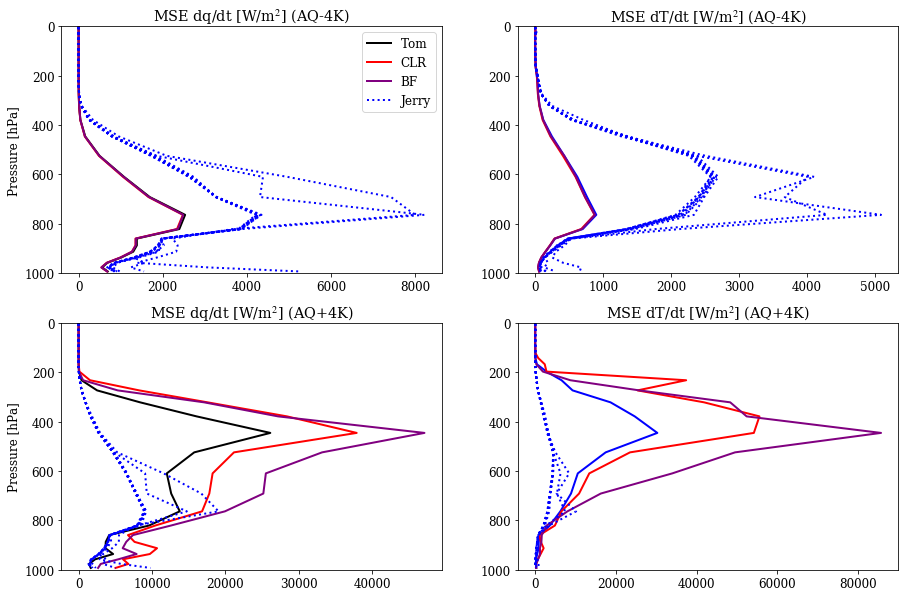

In [50]:
firsttime = 1; firsttime2 = 1;

fig, ax = plt.subplots(2,2,figsize=(15,10))

for row,dataset in enumerate(['AQ-4K','AQ+4K']):

    mse_q = np.mean(MSE_gen[dataset]['/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5'][:30,:],axis=1)
    mse_q2_1 = np.mean(MSE_gen[dataset]['/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_CLR_m4K_BF.hdf5']\
                       [30:60,:],axis=1)
    mse_q2_2 = np.mean(MSE_gen[dataset]['/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_m4K_BF.hdf5']\
                       [30:60,:],axis=1)
    if firsttime==1: label='Tom'; firsttime=0;
    else: label=''
    ax[row][0].plot(mse_q,lev,color=Color[0],label=label)
    ax[row][0].plot(mse_q2_1,lev,color='r',label='CLR')
    ax[row][0].plot(mse_q2_2,lev,color='purple',label='BF')
    ax[row][0].set_ylim((1000,0))
    ax[row][0].set_ylabel('Pressure [hPa]')
    ax[row][0].set_title('MSE dq/dt [W/m$^{2}$] ('+dataset+')')

    for dropout in range(5):
        for BN in (['True','False']):
            if firsttime2==1: label='Jerry'; firsttime2=0;
            else: label=''
            mse_q = np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][:30,:],axis=1)
            ax[row][0].plot(mse_q,lev,linestyle=':',color=Color[ipath],label=label)
    if row==0: ax[row][0].legend()


    mse_T = np.mean(MSE_gen[dataset]['/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5'][30:60,:],axis=1)
    mse_T2_1 = np.mean(MSE_gen[dataset]['/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_CLR_m4K_BF.hdf5']\
                       [:30,:],axis=1)
    mse_T2_2 = np.mean(MSE_gen[dataset]['/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2022_07_25_NN_BF_m4K_BF.hdf5']\
                       [:30,:],axis=1)
    ax[row][1].plot(mse_T,lev,color=Color[ipath])
    ax[row][1].plot(mse_T2_1,lev,color='r')
    ax[row][1].plot(mse_T2_2,lev,color='purple')
    ax[row][1].set_ylim((1000,0))
    ax[row][1].set_title('MSE dT/dt [W/m$^{2}$] ('+dataset+')')

    for dropout in range(5):
        for BN in (['True','False']):
            mse_T = np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][30:60,:],axis=1)
            ax[row][1].plot(mse_T,lev,linestyle=':',color=Color[ipath])



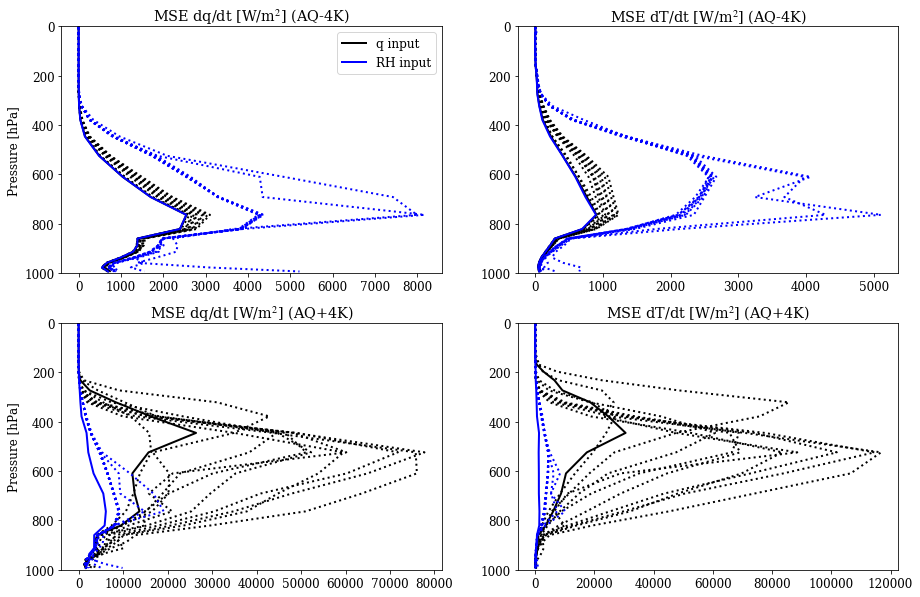

In [592]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

for row,dataset in enumerate(['AQ-4K','AQ+4K']):
    for ipath,path in enumerate(path_Tom):
        mse_q = np.mean(MSE_gen[dataset][path][:30,:],axis=1)
        ax[row][0].plot(mse_q,lev,label=Rescaling[ipath],color=Color[ipath])
        ax[row][0].set_ylim((1000,0))
        ax[row][0].set_ylabel('Pressure [hPa]')
        ax[row][0].set_title('MSE dq/dt [W/m$^{2}$] ('+dataset+')')
        
        for dropout in range(5):
            for BN in (['True','False']):
                mse_q = np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][:30,:],axis=1)
                ax[row][0].plot(mse_q,lev,linestyle=':',color=Color[ipath])
                
        
        mse_T = np.mean(MSE_gen[dataset][path][30:60,:],axis=1)
        ax[row][1].plot(mse_T,lev,color=Color[ipath])
        ax[row][1].set_ylim((1000,0))
        ax[row][1].set_title('MSE dT/dt [W/m$^{2}$] ('+dataset+')')
        
        for dropout in range(5):
            for BN in (['True','False']):
                mse_T = np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][30:60,:],axis=1)
                ax[row][1].plot(mse_T,lev,linestyle=':',color=Color[ipath])
        
    if row==0: ax[row][0].legend()

## R$^{2}$

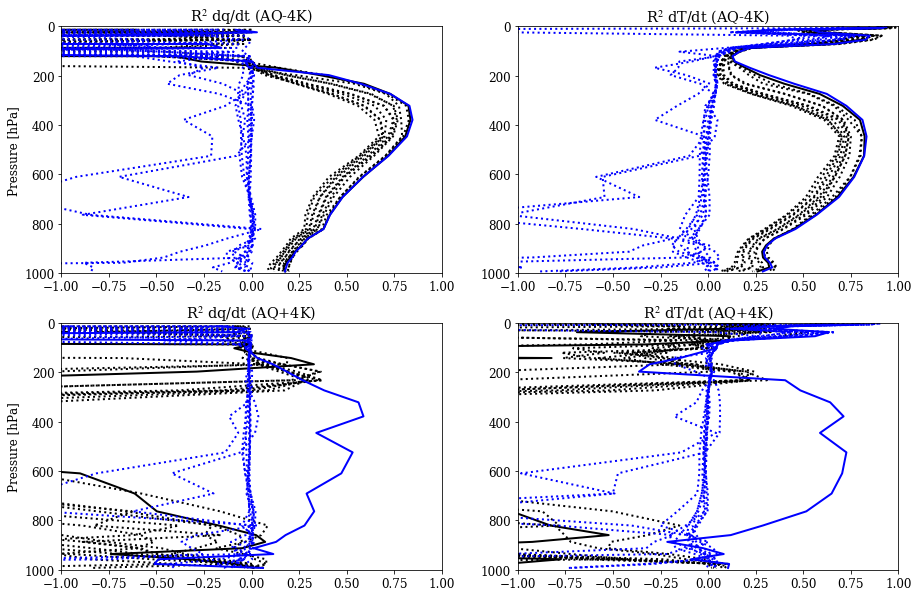

In [593]:
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(2,2,figsize=(15,10))

for row,dataset in enumerate(['AQ-4K','AQ+4K']):
    for ipath,path in enumerate(path_Tom):
        R2_q = 1-(np.mean(MSE_gen[dataset][path][:30,:],axis=1)/\
                  np.var(VAR[dataset][path][:,:,:,:30],axis=(0,1,2)))
        ax[row][0].plot(R2_q,lev,color=Color[ipath])
        ax[row][0].set_ylim((1000,0))
        ax[row][0].set_xlim((-1,1))
        ax[row][0].set_ylabel('Pressure [hPa]')
        ax[row][0].set_title('R$^{2}$ dq/dt ('+dataset+')')
        
        for dropout in range(5):
            for BN in (['True','False']):
                R2_q = 1-(np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][:30,:],axis=1)/\
                          (np.var(VAR[dataset][Inp_name[ipath]]\
                                  [dropout][BN][:,:,:,:30],axis=(0,1,2))))
                ax[row][0].plot(R2_q,lev,color=Color[ipath],linestyle=':')
        
        R2_T = 1-(np.mean(MSE_gen[dataset][path][30:60,:],axis=1)/\
                  np.var(VAR[dataset][path][:,:,:,30:60],axis=(0,1,2)))
        ax[row][1].plot(R2_T,lev,color=Color[ipath])
        ax[row][1].set_ylim((1000,0))
        ax[row][1].set_xlim((-1,1))
        ax[row][1].set_title('R$^{2}$ dT/dt ('+dataset+')')
        
        for dropout in range(5):
            for BN in (['True','False']):
                R2_T = 1-(np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][30:60,:],axis=1)/\
                          (np.var(VAR[dataset][Inp_name[ipath]]\
                                  [dropout][BN][:,:,:,30:60],axis=(0,1,2))))
                ax[row][1].plot(R2_T,lev,color=Color[ipath],linestyle=':')



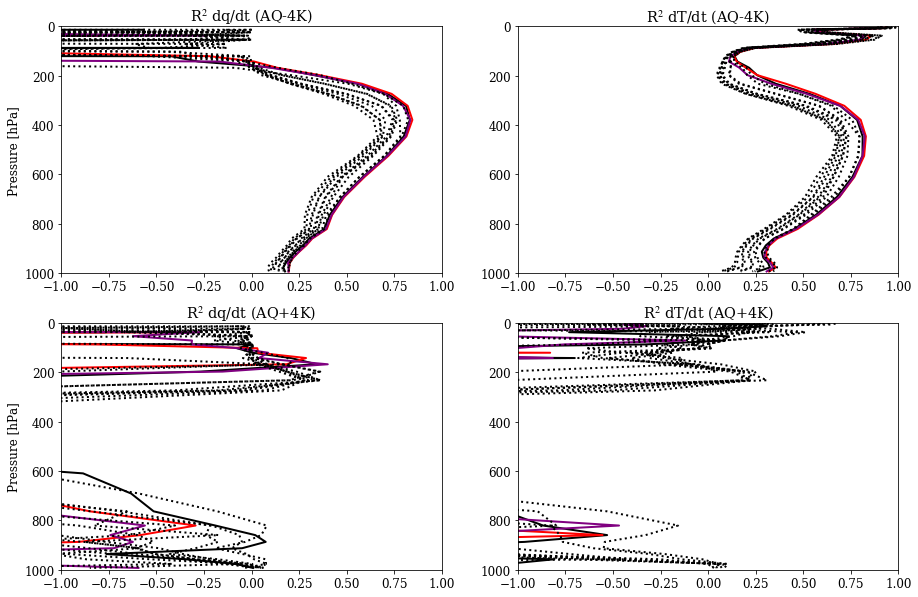

In [55]:
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(2,2,figsize=(15,10))

path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5'
ipath = 0
path2_1 = path_Tom_2[0]
path2_2 = path_Tom_2[1]

for row,dataset in enumerate(['AQ-4K','AQ+4K']):
    


    R2_q = 1-(np.mean(MSE_gen[dataset][path][:30,:],axis=1)/\
              np.var(VAR[dataset][path][:,:,:,:30],axis=(0,1,2)))
    R2_q1 = 1-(np.mean(MSE_gen[dataset][path2_1][30:60,:],axis=1)/\
              np.var(VAR[dataset][path2_1][:,:,:,30:60],axis=(0,1,2)))
    R2_q2 = 1-(np.mean(MSE_gen[dataset][path2_2][30:60,:],axis=1)/\
              np.var(VAR[dataset][path2_2][:,:,:,30:60],axis=(0,1,2)))
    ax[row][0].plot(R2_q,lev,color=Color[ipath])
    ax[row][0].plot(R2_q1,lev,color='r')
    ax[row][0].plot(R2_q2,lev,color='purple')
    ax[row][0].set_ylim((1000,0))
    ax[row][0].set_xlim((-1,1))
    ax[row][0].set_ylabel('Pressure [hPa]')
    ax[row][0].set_title('R$^{2}$ dq/dt ('+dataset+')')

    for dropout in range(5):
        for BN in (['True','False']):
            R2_q = 1-(np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][:30,:],axis=1)/\
                      (np.var(VAR[dataset][Inp_name[ipath]]\
                              [dropout][BN][:,:,:,:30],axis=(0,1,2))))
            ax[row][0].plot(R2_q,lev,color=Color[ipath],linestyle=':')

    R2_T = 1-(np.mean(MSE_gen[dataset][path][30:60,:],axis=1)/\
              np.var(VAR[dataset][path][:,:,:,30:60],axis=(0,1,2)))
    R2_T1 = 1-(np.mean(MSE_gen[dataset][path2_1][:30,:],axis=1)/\
              np.var(VAR[dataset][path2_1][:,:,:,:30],axis=(0,1,2)))
    R2_T2 = 1-(np.mean(MSE_gen[dataset][path2_2][:30,:],axis=1)/\
              np.var(VAR[dataset][path2_2][:,:,:,:30],axis=(0,1,2)))
    ax[row][1].plot(R2_T,lev,color=Color[ipath])
    ax[row][1].plot(R2_T1,lev,color='r')
    ax[row][1].plot(R2_T2,lev,color='purple')
    ax[row][1].set_ylim((1000,0))
    ax[row][1].set_xlim((-1,1))
    ax[row][1].set_title('R$^{2}$ dT/dt ('+dataset+')')

    for dropout in range(5):
        for BN in (['True','False']):
            R2_T = 1-(np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][30:60,:],axis=1)/\
                      (np.var(VAR[dataset][Inp_name[ipath]]\
                              [dropout][BN][:,:,:,30:60],axis=(0,1,2))))
            ax[row][1].plot(R2_T,lev,color=Color[ipath],linestyle=':')

## Compare MSE in W$^{2}$kg$^{-2}$ and W$^{2}$m$^{-4}$

In [57]:
conv_q = OUT[0][30:60]/scale_dict['PHQ']
conv_T = OUT[0][:30]/scale_dict['TPHYSTND']

In [68]:
print('Errors in W$^{2}$m$^{-4}$')
for row,dataset in enumerate(['AQ-4K','AQ+4K']):
    print(dataset)
    for ipath,path in enumerate(path_Tom):
        print(Inp_name[ipath])
        mse_q = np.mean(MSE_gen[dataset][path][:30,:],axis=1)
        mse_T = np.mean(MSE_gen[dataset][path][30:60,:],axis=1)
        print('Tom '+'%01.2e'%((mse_q).mean())+'/'+'%01.2e'%((mse_T).mean()))
        if ipath==0:
            for path2 in (path_Tom_2):
                mse_q = np.mean(MSE_gen[dataset][path2][30:60,:],axis=1)
                mse_T = np.mean(MSE_gen[dataset][path2][:30,:],axis=1)
                print('Tom2 '+'%01.2e'%((mse_q).mean())+'/'+'%01.2e'%((mse_T).mean()))
        for dropout in range(5):
            print('dropout=',str(dropout*10),'%')
            for BN in (['True','False']):
                mse_q = np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][:30,:],axis=1)
                mse_T = np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][30:60,:],axis=1)
                print('BN '+BN+' = '+'%01.2e'%((mse_q).mean())+'/'+'%01.2e'%((mse_T).mean()))

Errors in W$^{2}$m$^{-4}$
AQ-4K
Q
Tom 5.14e+02/1.63e+02
Tom2 5.02e+02/1.57e+02
Tom2 5.06e+02/1.60e+02
dropout= 0 %
BN True = 5.21e+02/1.73e+02
BN False = 5.16e+02/1.70e+02
dropout= 10 %
BN True = 5.45e+02/1.94e+02
BN False = 5.52e+02/2.02e+02
dropout= 20 %
BN True = 5.66e+02/2.08e+02
BN False = 5.71e+02/2.12e+02
dropout= 30 %
BN True = 5.92e+02/2.24e+02
BN False = 5.95e+02/2.29e+02
dropout= 40 %
BN True = 6.09e+02/2.36e+02
BN False = 6.20e+02/2.42e+02
RH
Tom 5.12e+02/1.60e+02
dropout= 0 %
BN True = 1.54e+03/7.64e+02
BN False = 1.18e+03/6.73e+02
dropout= 10 %
BN True = 8.96e+02/5.06e+02
BN False = 8.87e+02/4.90e+02
dropout= 20 %
BN True = 8.74e+02/4.87e+02
BN False = 8.74e+02/4.81e+02
dropout= 30 %
BN True = 8.72e+02/4.84e+02
BN False = 8.75e+02/4.86e+02
dropout= 40 %
BN True = 8.88e+02/4.93e+02
BN False = 8.87e+02/4.92e+02
AQ+4K
Q
Tom 4.63e+03/4.78e+03
Tom2 7.70e+03/9.56e+03
Tom2 8.42e+03/1.14e+04
dropout= 0 %
BN True = 8.29e+03/9.61e+03
BN False = 7.94e+03/1.20e+04
dropout= 10 %
BN Tr

In [69]:
print('Errors in W$^{2}$kg$^{-2}$')
for row,dataset in enumerate(['AQ-4K','AQ+4K']):
    print(dataset)
    for ipath,path in enumerate(path_Tom):
        print(Inp_name[ipath])
        mse_q = np.mean(MSE_gen[dataset][path][:30,:],axis=1)
        mse_T = np.mean(MSE_gen[dataset][path][30:60,:],axis=1)
        print('Tom '+'%01.2e'%(mse_q*(conv_q**2)).mean()+'/'+'%01.2e'%((mse_T*(conv_T**2)).mean()))
        if ipath==0:
            for path2 in (path_Tom_2):
                mse_q = np.mean(MSE_gen[dataset][path2][30:60,:],axis=1)
                mse_T = np.mean(MSE_gen[dataset][path2][:30,:],axis=1)
                print('Tom2 '+'%01.2e'%(mse_q*(conv_q**2)).mean()+'/'+'%01.2e'%((mse_T*(conv_T**2)).mean()))
        for dropout in range(5):
            print('dropout=',str(dropout*10),'%')
            for BN in (['True','False']):
                mse_q = np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][:30,:],axis=1)
                mse_T = np.mean(MSE_gen[dataset][Inp_name[ipath]][dropout][BN][30:60,:],axis=1)
                print('BN '+BN+' '+'%01.2e'%(mse_q*(conv_q**2)).mean()+'/'+'%01.2e'%((mse_T*(conv_T**2)).mean()))

Errors in W$^{2}$kg$^{-2}$
AQ-4K
Q
Tom 5.31e-03/8.84e-04
Tom2 5.18e-03/8.48e-04
Tom2 5.20e-03/8.65e-04
dropout= 0 %
BN True 5.27e-03/8.74e-04
BN False 5.25e-03/8.73e-04
dropout= 10 %
BN True 5.42e-03/9.65e-04
BN False 5.45e-03/9.84e-04
dropout= 20 %
BN True 5.59e-03/1.03e-03
BN False 5.60e-03/1.04e-03
dropout= 30 %
BN True 5.77e-03/1.09e-03
BN False 5.77e-03/1.11e-03
dropout= 40 %
BN True 5.87e-03/1.14e-03
BN False 5.97e-03/1.16e-03
RH
Tom 5.28e-03/8.67e-04
dropout= 0 %
BN True 1.81e-02/4.24e-03
BN False 9.98e-03/2.56e-03
dropout= 10 %
BN True 7.71e-03/1.87e-03
BN False 7.50e-03/1.87e-03
dropout= 20 %
BN True 7.27e-03/1.74e-03
BN False 7.35e-03/1.74e-03
dropout= 30 %
BN True 7.23e-03/1.76e-03
BN False 7.33e-03/1.82e-03
dropout= 40 %
BN True 7.51e-03/1.78e-03
BN False 7.56e-03/1.81e-03
AQ+4K
Q
Tom 2.25e-02/1.54e-02
Tom2 5.08e-02/3.61e-02
Tom2 4.06e-02/3.20e-02
dropout= 0 %
BN True 3.74e-02/2.97e-02
BN False 3.92e-02/4.25e-02
dropout= 10 %
BN True 1.90e-02/1.17e-02
BN False 2.63e-02/1.84